In [43]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

np.random.seed(42)
def sigmoid(x): return 1/(1+np.exp(-x))
def draw_annotated_network(node_values, biases, weights, figsize=(7,6)):
    pos = {'x1':(0,1), 'x2':(0,-1), 'h1':(2,1), 'h2':(2,-1), 'y':(4,0)}
    bg_colors = {'x1':'deepskyblue', 'x2':'deepskyblue', 'h1':'palevioletred', 'h2':'palevioletred', 'y':'gold'}
    fig,ax = plt.subplots(figsize=figsize)
    G = nx.DiGraph()
    G.add_nodes_from(pos.keys())
    for i in ['x1','x2']:
        for h in ['h1','h2']:
            G.add_edge(i,h)
    for h in ['h1','h2']:
        G.add_edge(h,'y')
    for n in pos:
        val = node_values.get(n, '')
        val_str = f'{float(val):.3f}' if val not in ('','None') else ''
        node_label = f"{n}\n{val_str}" if val_str else f"{n}"
        circle = plt.Circle(pos[n], 0.40, color=bg_colors[n], ec='k', lw=2, zorder=3)
        ax.add_patch(circle)
        plt.text(pos[n][0], pos[n][1], node_label, fontweight='bold', fontsize=15, ha='center', va='center', zorder=4)
        if n in biases:
            plt.text(pos[n][0]-0.2, pos[n][1]+0.43, f"b={biases[n]:.3f}", color='slategray', fontsize=11, ha='center', va='bottom')
    def signcolor(w): return 'forestgreen' if w >= 0 else 'firebrick'
    for (u,v) in G.edges():
        w = weights[(u,v)]
        color = signcolor(w)
        dx, dy = pos[v][0]-pos[u][0], pos[v][1]-pos[u][1]
        mag = abs(w)
        ax.arrow(pos[u][0], pos[u][1], dx*0.7, dy*0.7, head_width=0.17, head_length=0.30, fc=color, ec=color, length_includes_head=True, linewidth=2+6*mag, alpha=0.65, zorder=2)
        offx = pos[u][0]+dx*0.5 + (0.13 if dy<0 else -0.13)
        offy = pos[u][1]+dy*0.5 + (0.13 if dx==0 else 0)
        plt.text(offx, offy, f"w={w:.3f}", color=color, fontsize=11, ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white',edgecolor='none', alpha=0.7))
    plt.axis('off'); plt.xlim(-1,5); plt.ylim(-2.2,2); plt.tight_layout(); plt.show()

# Let's construct and analyze a tiny and simple FCFF ANN

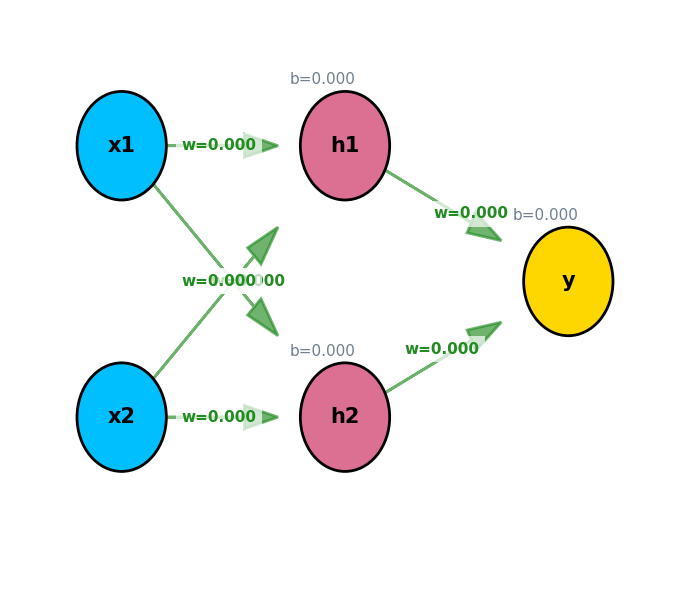

In [44]:
# Draw empty network (all vals = 0, no activations)
node_vals = {'x1': '', 'x2': '', 'h1': '', 'h2': '', 'y': ''}
bias_dict = {'h1': 0.0, 'h2': 0.0, 'y': 0.0}
weight_dict = {
    ('x1','h1'): 0.0,
    ('x2','h1'): 0.0,
    ('x1','h2'): 0.0,
    ('x2','h2'): 0.0,
    ('h1','y'): 0.0,
    ('h2','y'): 0.0
}
draw_annotated_network(node_vals, bias_dict, weight_dict)

# First let's assign initial weights, biases, inputs, and target output

Inputs and target output:
$$
x_1 = 1.0 \qquad x_2 = 2.0 \qquad t = -0.5
$$

Weights & biases:
$$
w_{x1,h1}=0.200,\; w_{x2,h1}=0.400,\; b_{h1}=0.100 \\
w_{x1,h2}=0.300,\; w_{x2,h2}=0.700,\; b_{h2}=-0.300 \\
w_{h1,y}=0.600,\; w_{h2,y}=0.900,\; b_y=0.200
$$

Learning rate:
$$
\eta=0.1
$$

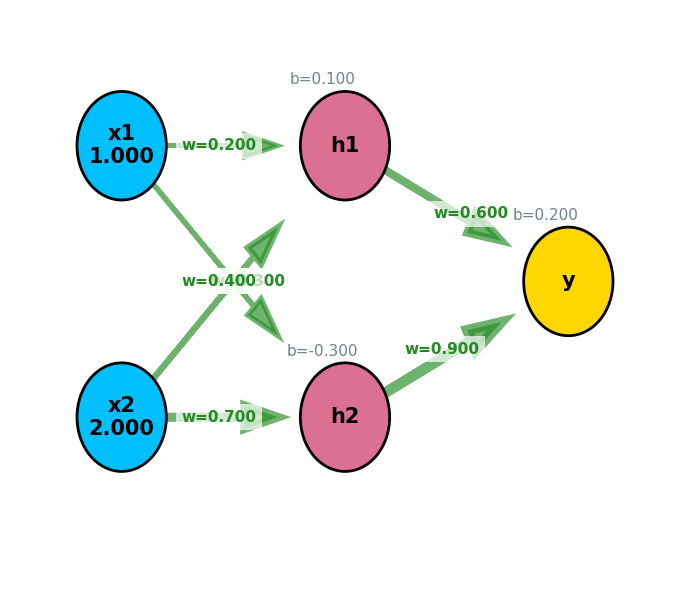

In [45]:
x1, x2 = 1.0, 2.0
t = -0.5
eta = 0.1
node_vals = {'x1':f'{x1:.3f}','x2':f'{x2:.3f}','h1':'','h2':'','y':''}
bias_dict = {'h1':0.1,'h2':-0.3,'y':0.2}
weight_dict = {('x1','h1'):0.2,('x2','h1'):0.4,('x1','h2'):0.3,('x2','h2'):0.7,('h1','y'):0.6,('h2','y'):0.9}
draw_annotated_network(node_vals, bias_dict, weight_dict)

# Let's do a layer-by-layer forward pass

OK, so we know our inputs and we have initialized the input weights and biases, let's compute the network output and see how close it is to the target value given by the training data.

So we can consider $(x_1,x_2)$ and $t$ as an input-output pair defining a **training example**. If the network produces an output very close to the target when we present that input, it is performing well. If it does not, then we need to update the weights and biases by **network training**.

In general we have lots of training data, but in this super simple example we will look at just one such training example and analyze how the network behaves in forward (i.e., prediction) mode when we present the training inputs, and how we can then run the network in backward (i.e., training) mode to update its weights and biases and improve its predictions.

### Hidden Layer Forward Math
$$
z_j = x_1 w_{x1,hj} + x_2 w_{x2,hj} + b_{hj} \\
h_j = \sigma(z_j) = \frac{1}{1 + e^{-z_j}}
$$

z1 = 1.000 * 0.200 + 2.000 * 0.400 + 0.100 = 1.100
z2 = 1.000 * 0.300 + 2.000 * 0.700 + -0.300 = 1.400
h1 = sigmoid(1.100) = 0.750
h2 = sigmoid(1.400) = 0.802


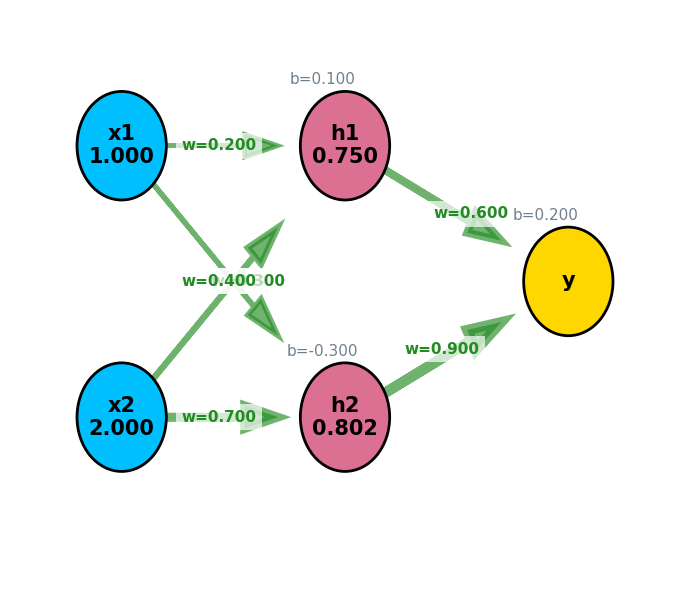

In [18]:
z1 = x1 * weight_dict[('x1','h1')] + x2 * weight_dict[('x2','h1')] + bias_dict['h1']
z2 = x1 * weight_dict[('x1','h2')] + x2 * weight_dict[('x2','h2')] + bias_dict['h2']
h1 = sigmoid(z1)
h2 = sigmoid(z2)
node_vals['h1'] = f'{h1:.3f}'
node_vals['h2'] = f'{h2:.3f}'
print(f"z1 = {x1:.3f} * {weight_dict[('x1','h1')]:.3f} + {x2:.3f} * {weight_dict[('x2','h1')]:.3f} + {bias_dict['h1']:.3f} = {z1:.3f}")
print(f"z2 = {x1:.3f} * {weight_dict[('x1','h2')]:.3f} + {x2:.3f} * {weight_dict[('x2','h2')]:.3f} + {bias_dict['h2']:.3f} = {z2:.3f}")
print(f"h1 = sigmoid({z1:.3f}) = {h1:.3f}")
print(f"h2 = sigmoid({z2:.3f}) = {h2:.3f}")
draw_annotated_network(node_vals, bias_dict, weight_dict)

### Output Layer Forward Math
$$
z_y = h_1 w_{h1,y} + h_2 w_{h2,y} + b_y\\
y_{pred} = \sigma(z_y) = \frac{1}{1 + e^{-z_y}}
$$

z_y = 0.745 * 0.600 + 0.796 * 0.900 + 0.200 = 1.364
y_pred = sigmoid(1.364) = 0.796


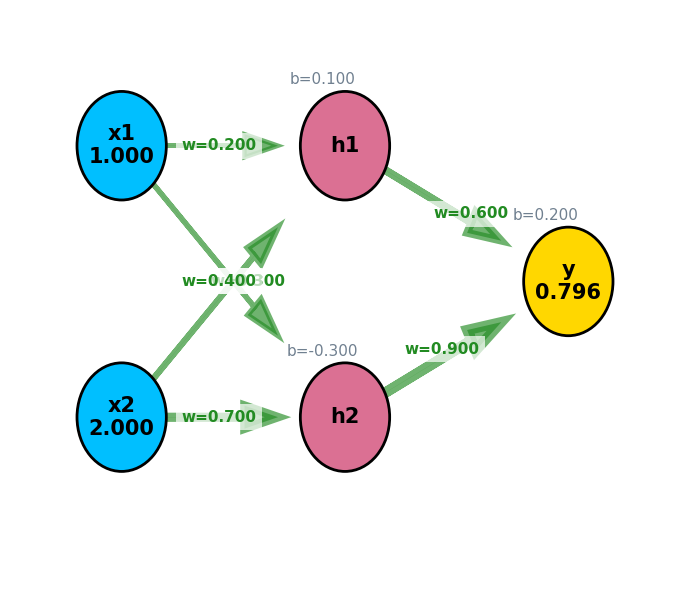

In [46]:
z_y = h1 * weight_dict[('h1','y')] + h2 * weight_dict[('h2','y')] + bias_dict['y']
y_pred = sigmoid(z_y)
node_vals['y'] = f'{y_pred:.3f}'
print(f"z_y = {h1:.3f} * {weight_dict[('h1','y')]:.3f} + {h2:.3f} * {weight_dict[('h2','y')]:.3f} + {bias_dict['y']:.3f} = {z_y:.3f}")
print(f"y_pred = sigmoid({z_y:.3f}) = {y_pred:.3f}")
draw_annotated_network(node_vals, bias_dict, weight_dict)

# How well did we do?

### Error Calculation
$$
E = \frac{1}{2}(t - y_{pred})^2
$$

In [47]:
E = 0.5 * (t - y_pred)**2
print(f"E = 0.5 * ({t:.3f} - {y_pred:.3f})^2 = {E:.5f}")

E = 0.5 * (-0.500 - 0.796)^2 = 0.84030


Probably not so great! Looks like we need to use **backpropagation** to update the network parameters (i.e., the weights and biases) to get the output to be closer to the target value. This is network training!

# Let's do a layer-by-layer backward pass

### First Recall the Forward Pass Math Expressions

The output \$y_{pred}\$ is computed by:

$$
y_{pred} = \sigma(z_y) = \frac{1}{1 + e^{-z_y}}
$$

where

$$
z_y = h_1 w_{h1,y} + h_2 w_{h2,y} + b_y
$$

where

$$
h_j = \sigma(z_j) = \frac{1}{1 + e^{-z_j}}
$$

where

$$
z_1 = x_1 w_{x1,h1} + x_2 w_{x2,h1} + b_{h1} \\
z_2 = x_1 w_{x1,h2} + x_2 w_{x2,h2} + b_{h2}
$$

<br />

Phew! This is a long neseted set of equations that take us all the way from the output back through the network to its inputs. However ugly it is, it's nothing more than one very long equation and its gradients with respect to the various parameters (i.e., network weights and biases can be computed using the **chain rule**).

### The Loss Function

Once we have $y_{pred}$, it is easy to compute the loss function:

$$
E = \frac{1}{2} \left( t - y_{pred} \right)^2
$$

### Output Layer Weight and Bias Updates

To update the weights and biases on the single node in the output layer \$w_{h1,y}\$, \$w_{h2,y}\$, and \$b_y\$ we will use **backpropagation**. Remember, all that backprop does is ask the loss function how sensitive it is to small changes in each of the network weight and bias parameters.

We compute the **gradient in the loss function with respect to the network parameters** and then take a small step downhill in the loss function surface.

The size of the step downhill is controlled by the **learning rate**.

So, we need to compute the gradients \$ \frac{\partial E}{\partial w_{h1,y}} \$, \$ \frac{\partial E}{\partial w_{h2,y}} \$, and \$ \frac{\partial E}{\partial b_y} \$ in order to figure out how to take a step downhill in each of these parameters.

Since \$E\$ is a function of \$y_{pred}\$, which is a function of \$z_y\$, which is a function of \$w_{h1,y}\$, \$w_{h2,y}\$, and \$b_y\$, we need to use the **chain rule** for the win:

<br />

$$
\frac{\partial E}{\partial w_{h1,y}} =
\frac{\partial E}{\partial y_{pred}} \cdot
\frac{\partial y_{pred}}{\partial z_y} \cdot
\frac{\partial z_y}{\partial w_{h1,y}}
$$


$$
\frac{\partial E}{\partial w_{h2,y}} =
\frac{\partial E}{\partial y_{pred}} \cdot
\frac{\partial y_{pred}}{\partial z_y} \cdot
\frac{\partial z_y}{\partial w_{h2,y}}
$$

$$
\frac{\partial E}{\partial b_y} =
\frac{\partial E}{\partial y_{pred}} \cdot
\frac{\partial y_{pred}}{\partial z_y} \cdot
\frac{\partial z_y}{\partial b_y}
$$

<br />

Let's collect all the forward pass and loss function equations here:

- $ E = \frac{1}{2} \left( t - y_{pred} \right)^2 $
- $ y_{pred} = \sigma(z_y) = \frac{1}{1 + e^{-z_y}} $
- $ z_y = h_1 w_{h1,y} + h_2 w_{h2,y} + b_y $
- $ h_j = \sigma(z_j) = \frac{1}{1 + e^{-z_j}} $
- $ z_1 = x_1 w_{x1,h1} + x_2 w_{x2,h1} + b_{h1} $
- $ z_2 = x_1 w_{x1,h2} + x_2 w_{x2,h2} + b_{h2} $

<br />

Now, let's take the derivatives that we need:

- $ \frac{\partial E}{\partial y_{pred}} = y_{pred} - t $
- $ \frac{\partial y_{pred}}{\partial z_y} = y_{pred}(1 - y_{pred}) $
- $ \frac{\partial z_y}{\partial w_{h1,y}} = h_1 $
- $ \frac{\partial z_y}{\partial w_{h2,y}} = h_2 $
- $ \frac{\partial z_y}{\partial b_y} = 1 $

The second one involving the derivative of the sigmoid function is a little more involved - here's the step-by-step:

$
\frac{d y_{pred}}{d z_y}
$

$
=\frac{d}{d z_y} \left( \frac{1}{1 + e^{-z_y}} \right )
$

$
= \frac{e^{-z_y}}{(1 + e^{-z_y})^2}
$ (quotient rule)

$
= \frac{1}{1 + e^{-z_y}} \cdot \frac{e^{-z_y}}{1 + e^{-z_y}}
$

$
= \frac{1}{1 + e^{-z_y}} \cdot \left(1 - \frac{1}{1 + e^{-z_y}}\right)
$

$
= y_{pred}(1 - y_{pred})
$


<br />

Now, putting it all together:

$$
\frac{\partial E}{\partial w_{h1,y}} = (y_{pred} - t) \cdot y_{pred}(1-y_{pred}) \cdot h_1
$$

$$
\frac{\partial E}{\partial w_{h2,y}} = (y_{pred} - t) \cdot y_{pred}(1-y_{pred}) \cdot h_2
$$

$$
\frac{\partial E}{\partial b_y} = (y_{pred} - t) \cdot y_{pred}(1-y_{pred})
$$

<br />

For simplicity, we can define:

$$\delta_y = (y_{pred} - t) \cdot y_{pred}(1-y_{pred})$$

and write compactly as:

$$
\frac{\partial E}{\partial w_{h1,y}} = \delta_y\, h_1 \\
\frac{\partial E}{\partial w_{h2,y}} = \delta_y\, h_2 \\
\frac{\partial E}{\partial b_y} = \delta_y
$$

<br />

So our backprop update rules:

$$
w_{h1,y}^{new} = w_{h1,y} - \eta \frac{\partial E}{\partial w_{h1,y}} \\
w_{h2,y}^{new} = w_{h2,y} - \eta \frac{\partial E}{\partial w_{h2,y}} \\
b_y^{new} = b_y - \eta \frac{\partial E}{\partial b_y}
$$

become:

$$
w_{h1,y}^{new} = w_{h1,y} - \eta \delta_y\, h_1 \\
w_{h2,y}^{new} = w_{h2,y} - \eta \delta_y\, h_2 \\
b_y^{new} = b_y - \eta \delta_y
$$


delta_y = (0.796 - -0.500) * 0.796 * (1 - 0.796) = 0.210218
w_h1y_new = 0.600 - 0.100 * (0.210218 * 0.745) = 0.584
w_h2y_new = 0.900 - 0.100 * (0.210218 * 0.796) = 0.883
b_y_new = 0.200 - 0.100 * 0.210218 = 0.179


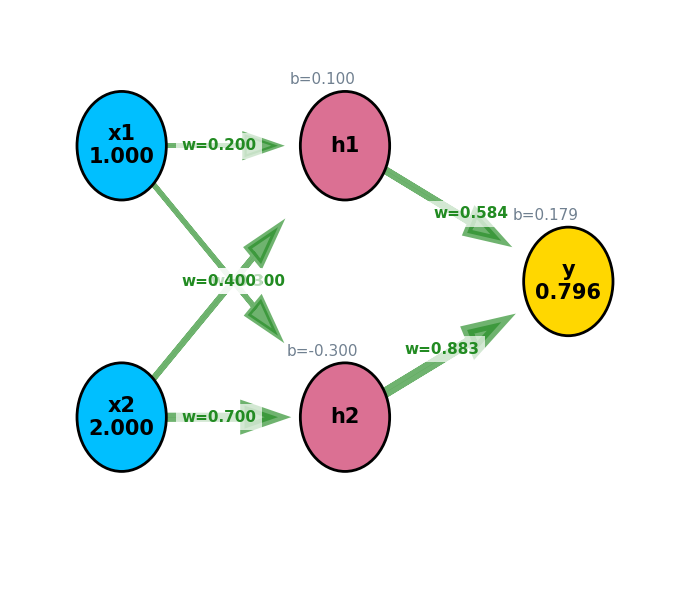

In [48]:
old_wh1y = weight_dict[('h1','y')]
old_wh2y = weight_dict[('h2','y')]
old_by = bias_dict['y']
delta_y = (y_pred - t) * y_pred * (1 - y_pred)
grad_wh1_y = delta_y * h1
grad_wh2_y = delta_y * h2
grad_by = delta_y
weight_dict[('h1','y')] -= eta * grad_wh1_y
weight_dict[('h2','y')] -= eta * grad_wh2_y
bias_dict['y'] -= eta * grad_by
print(f"delta_y = ({y_pred:.3f} - {t:.3f}) * {y_pred:.3f} * (1 - {y_pred:.3f}) = {delta_y:.6f}")
print(f"w_h1y_new = {old_wh1y:.3f} - {eta:.3f} * ({delta_y:.6f} * {h1:.3f}) = {weight_dict[('h1','y')]:.3f}")
print(f"w_h2y_new = {old_wh2y:.3f} - {eta:.3f} * ({delta_y:.6f} * {h2:.3f}) = {weight_dict[('h2','y')]:.3f}")
print(f"b_y_new = {old_by:.3f} - {eta:.3f} * {delta_y:.6f} = {bias_dict['y']:.3f}")
draw_annotated_network(node_vals, bias_dict, weight_dict)

### Hidden Layer Weight and Bias Updates

We will now apply backpropagation to update the weights and biases on the first of the two nodes in the hidden layer \$w_{x1,h1}\$, \$w_{x2,h1}\$, and \$b_{h1}\$. (The expressions and procedure are completely analogous for the second node in the hidden layer, so we will not write these explicitly here but we will make the update in the code below.)

OK, so this time we need the gradients \$ \frac{\partial E}{\partial w_{h1,y}} \$, \$ \frac{\partial E}{\partial w_{h2,y}} \$, and \$ \frac{\partial E}{\partial b_y} \$.

<br />

Looking back at the forward pass equations, we see that \$E\$ is a function of \$y_{pred}\$, which is a function of \$z_y\$, which is a function of \$h_1\$, which is a function of \$z_1\$, which is a function of $w_{x1,h1}\$, \$w_{x2,h1}\$, and \$b_{h1}\$.

So we see that the further back we go in the network the more complicated and nested the expressions become.

Again, appealing to the chain rule:

<br />

$$
\frac{\partial E}{\partial w_{x1,h1}} =
\frac{\partial E}{\partial y_{pred}}
\cdot \frac{\partial y_{pred}}{\partial z_y}
\cdot \frac{\partial z_y}{\partial h_1}
\cdot \frac{\partial h_1}{\partial z_1}
\cdot \frac{\partial z_1}{\partial w_{x1,h1}}
$$

$$
\frac{\partial E}{\partial w_{x2,h1}} =
\frac{\partial E}{\partial y_{pred}}
\cdot \frac{\partial y_{pred}}{\partial z_y}
\cdot \frac{\partial z_y}{\partial h_1}
\cdot \frac{\partial h_1}{\partial z_1}
\cdot \frac{\partial z_1}{\partial w_{x2,h1}}
$$

$$
\frac{\partial E}{\partial b_{h1}} =
\frac{\partial E}{\partial y_{pred}}
\cdot \frac{\partial y_{pred}}{\partial z_y}
\cdot \frac{\partial z_y}{\partial h_1}
\cdot \frac{\partial h_1}{\partial z_1}
\cdot \frac{\partial z_1}{\partial b_{h1}}
$$

<br />

Let's collect all the forward pass and loss function equations here:

- $ E = \frac{1}{2} \left( t - y_{pred} \right)^2 $
- $ y_{pred} = \sigma(z_y) = \frac{1}{1 + e^{-z_y}} $
- $ z_y = h_1 w_{h1,y} + h_2 w_{h2,y} + b_y $
- $ h_j = \sigma(z_j) = \frac{1}{1 + e^{-z_j}} $
- $ z_1 = x_1 w_{x1,h1} + x_2 w_{x2,h1} + b_{h1} $
- $ z_2 = x_1 w_{x1,h2} + x_2 w_{x2,h2} + b_{h2} $

<br />

Now, let's take the derivatives that we need:

- \$ \frac{\partial E}{\partial y_{pred}} = y_{pred} - t \$
- \$ \frac{\partial y_{pred}}{\partial z_y} = y_{pred}(1-y_{pred}) \$
- \$ \frac{\partial z_y}{\partial h_1} = w_{h1,y} \$
- \$ \frac{\partial h_1}{\partial z_1} = h_1(1-h_1) \$
- \$ \frac{\partial z_1}{\partial w_{x1,h1}} = x_1 \$
- \$ \frac{\partial z_1}{\partial w_{x2,h1}} = x_2 \$
- \$ \frac{\partial z_1}{\partial b_{h1}} = 1 \$

<br />

For the second and fourth derivatives, remember the expression we learned above for the derivative of a sigmoid?

<br />

Now putting it all together:

$$
\frac{\partial E}{\partial w_{x1,h1}} = (y_{pred} - t)\, y_{pred}(1-y_{pred})\, w_{h1,y}\, h_1(1-h_1)\, x_1
$$

$$
\frac{\partial E}{\partial w_{x2,h1}} = (y_{pred} - t)\, y_{pred}(1-y_{pred})\, w_{h1,y}\, h_1(1-h_1)\, x_2
$$

$$
\frac{\partial E}{\partial b_{h1}} = (y_{pred} - t)\, y_{pred}(1-y_{pred})\, w_{h1,y}\, h_1(1-h_1)
$$

<br />

And defining for simplicity:

$$
\delta_{h1} = (y_{pred} - t) \cdot y_{pred}(1-y_{pred}) w_{h1,y} h_1(1-h_1)
$$

we can write compactly as:

$$
\frac{\partial E}{\partial w_{x1,h1}} = \delta_{h1} x_1 \\
\frac{\partial E}{\partial w_{x2,h1}} = \delta_{h1} x_2 \\
\frac{\partial E}{\partial b_{h1}} = \delta_{h1}
$$

<br />

And our backprop update rules:

$$
w_{x1,h1}^{new} = w_{x1,h1} - \eta \frac{\partial E}{\partial w_{x1,h1}} \\
w_{x2,h1}^{new} = w_{x2,h1} - \eta \frac{\partial E}{\partial w_{x2,h1}} \\
b_{h1}^{new} = b_{h1} - \eta \frac{\partial E}{\partial b_{h1}}
$$

become:

$$
w_{x1,h1}^{new} = w_{x1,h1} - \eta \delta_{h1} x_1 \\
w_{x2,h1}^{new} = w_{x2,h1} - \eta \delta_{h1} x_2 \\
b_{h1}^{new} = b_{h1} - \eta \delta_{h1}
$$

delta_h1 = 0.210218 * 0.584 * 0.745 * (1 - 0.745) = 0.023336
w_x1h1_new = 0.200 - 0.100 * (0.023336 * 1.0) = 0.198
w_x2h1_new = 0.400 - 0.100 * (0.023336 * 2.0) = 0.395
b_h1_new = 0.100 - 0.100 * 0.023336 = 0.098
delta_h2 = 0.210218 * 0.883 * 0.796 * (1 - 0.796) = 0.030098
w_x1h2_new = 0.300 - 0.100 * (0.030098 * 1.0) = 0.297
w_x2h2_new = 0.700 - 0.100 * (0.030098 * 2.0) = 0.694
b_h2_new = -0.300 - 0.100 * 0.030098 = -0.303


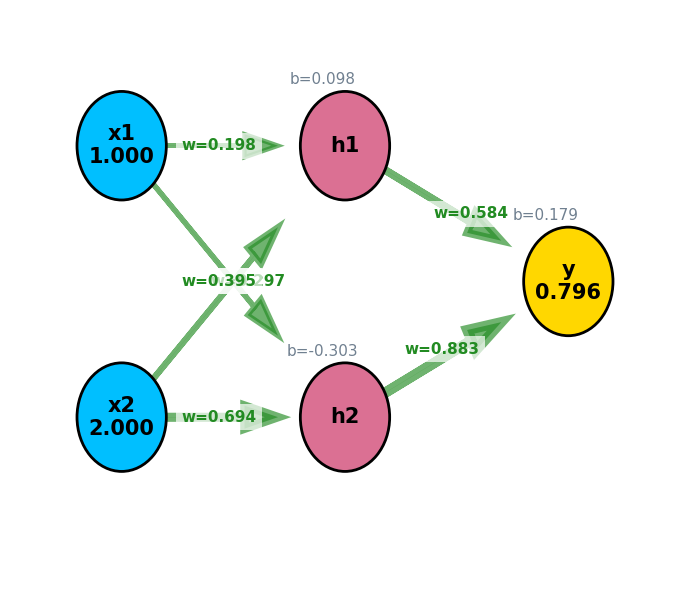

In [49]:
old_wx1h1 = weight_dict[('x1','h1')]
old_wx2h1 = weight_dict[('x2','h1')]
old_bh1 = bias_dict['h1']
old_wx1h2 = weight_dict[('x1','h2')]
old_wx2h2 = weight_dict[('x2','h2')]
old_bh2 = bias_dict['h2']
delta_h1 = delta_y * weight_dict[('h1','y')] * h1 * (1 - h1)
delta_h2 = delta_y * weight_dict[('h2','y')] * h2 * (1 - h2)
grad_wx1_h1 = delta_h1 * x1
grad_wx2_h1 = delta_h1 * x2
grad_bh1 = delta_h1
grad_wx1_h2 = delta_h2 * x1
grad_wx2_h2 = delta_h2 * x2
grad_bh2 = delta_h2
weight_dict[('x1','h1')] -= eta * grad_wx1_h1
weight_dict[('x2','h1')] -= eta * grad_wx2_h1
bias_dict['h1'] -= eta * grad_bh1
weight_dict[('x1','h2')] -= eta * grad_wx1_h2
weight_dict[('x2','h2')] -= eta * grad_wx2_h2
bias_dict['h2'] -= eta * grad_bh2
print(f"delta_h1 = {delta_y:.6f} * {weight_dict[('h1','y')]:.3f} * {h1:.3f} * (1 - {h1:.3f}) = {delta_h1:.6f}")
print(f"w_x1h1_new = {old_wx1h1:.3f} - {eta:.3f} * ({delta_h1:.6f} * {x1:.1f}) = {weight_dict[('x1','h1')]:.3f}")
print(f"w_x2h1_new = {old_wx2h1:.3f} - {eta:.3f} * ({delta_h1:.6f} * {x2:.1f}) = {weight_dict[('x2','h1')]:.3f}")
print(f"b_h1_new = {old_bh1:.3f} - {eta:.3f} * {delta_h1:.6f} = {bias_dict['h1']:.3f}")
print(f"delta_h2 = {delta_y:.6f} * {weight_dict[('h2','y')]:.3f} * {h2:.3f} * (1 - {h2:.3f}) = {delta_h2:.6f}")
print(f"w_x1h2_new = {old_wx1h2:.3f} - {eta:.3f} * ({delta_h2:.6f} * {x1:.1f}) = {weight_dict[('x1','h2')]:.3f}")
print(f"w_x2h2_new = {old_wx2h2:.3f} - {eta:.3f} * ({delta_h2:.6f} * {x2:.1f}) = {weight_dict[('x2','h2')]:.3f}")
print(f"b_h2_new = {old_bh2:.3f} - {eta:.3f} * {delta_h2:.6f} = {bias_dict['h2']:.3f}")
draw_annotated_network(node_vals, bias_dict, weight_dict)

## Training step complete! 🎉
Weights and biases above reflect learning.

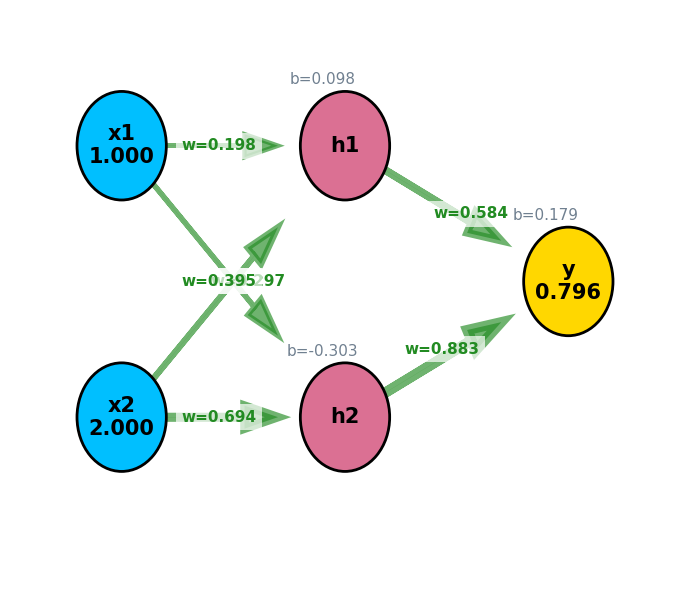

In [50]:
draw_annotated_network(node_vals, bias_dict, weight_dict)

# How well did we do?

### Error Calculation
$$
E = \frac{1}{2}(t - y_{pred})^2
$$

In [51]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Compute hidden layer preactivations
z1 = float(node_vals['x1']) * weight_dict[('x1','h1')] + float(node_vals['x2']) * weight_dict[('x2','h1')] + bias_dict['h1']
z2 = float(node_vals['x1']) * weight_dict[('x1','h2')] + float(node_vals['x2']) * weight_dict[('x2','h2')] + bias_dict['h2']

# Activations for hidden layer
h1 = sigmoid(z1)
h2 = sigmoid(z2)

# Compute output preactivation and activation
z_y = h1 * weight_dict[('h1','y')] + h2 * weight_dict[('h2','y')] + bias_dict['y']
y_pred = sigmoid(z_y)

print("y_pred =", y_pred)

y_pred = 0.7894868458372377


In [52]:
E = 0.5 * (t - y_pred)**2
print(f"E = 0.5 * ({t:.3f} - {y_pred:.3f})^2 = {E:.5f}")

E = 0.5 * (-0.500 - 0.789)^2 = 0.83139


Hopefully you have seen the loss function to get better after we completed one pass of backprop training! If not, perhaps you may need to adjust your learning rate.